# Minimizzazione misura disuguaglianza CHSH su stati noti

- Dicotomic Projector: classe per definire i proiettori quantistici per Alice o Bob lungo un versore sulla sfera di Bloch specificato dall' array direction

- Bell Ensemble: specifica la matrice densitá dello stato quantistico sul quale si vogliono operare le misure

- OptimizationRun: classe che opera la minimizzazione 'esatta' del valore di CHSH per stato quantistico dato.

- OptimizationExperimental: versione 'sperimentale' della minimizzazione che assume N eventi per setup di misura.



In [1]:
from qutip import *
import numpy as np
import scipy
import pybobyqa
import matplotlib.pyplot as plt
from skopt import gp_minimize
%matplotlib inline

In [2]:
class DicotomicProjector:
    def __init__(self, direction):
        sigma = [sigmax(),sigmay(),sigmaz()]
        self.dp_plus = 0.5*qeye(2)
        self.dp_minus = 0.5*qeye(2)
        for i in range(3):
            self.dp_plus += 0.5*direction[i]*sigma[i]
            self.dp_minus -= 0.5*direction[i]*sigma[i]
        self.dp = self.dp_plus - self.dp_minus #A = A^+ - A^-
        
class BellEnsemble:
    def __init__(self, p, q=0):
        #Generazione dello stato, se q=0 ho lo stato di Werner al variare di p, altrimenti ho lo stato composto
        self.p = p
        self.q = q
        bell_s = (tensor(basis(2,0),basis(2,1))-tensor(basis(2,1),basis(2,0)))/np.sqrt(2)
        bell_a = (tensor(basis(2,0),basis(2,0))+tensor(basis(2,1),basis(2,1)))/np.sqrt(2)
        self.rho = p*bell_s*bell_s.dag() + (1 - p)*(0.5*q*(bell_s*bell_s.dag() + bell_t*bell_t.dag())+(1-q)*(tensor(qeye(2),qeye(2))/4))
        
class OptimizationRun:
    def __init__(self, state, x0=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]):
        self.state = state
        self.history = []
        self.x0 = x0
        self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho),
                                           method='Nelder-Mead', callback=self.displayProgress,
                                           options={'disp':True, 'maxiter':4000, 'xatol':0.0001,
                                                    'fatol':0.0001, 'adaptive':True})
    def dirvector(self, angles):
        return [np.cos(angles[0])*np.sin(angles[1]),np.sin(angles[0])*np.sin(angles[1]),np.cos(angles[1])]
    
    def func_free(self, x, rho):
        #rho è la matrice densità fissata in input
        a0 = self.dirvector(x[0:2])
        a1 = self.dirvector(x[2:4])
        b0 = self.dirvector(x[4:6])
        b1 = self.dirvector(x[6:8])

        A0 = DicotomicProjector(a0)
        A1 = DicotomicProjector(a1)
        B0 = DicotomicProjector(b0)
        B1 = DicotomicProjector(b1)
        #.real serve perche' qutip da' valore complesso in output
        return ((tensor(A0.dp,B0.dp)*rho).tr() + (tensor(A0.dp,B1.dp)*rho).tr() + (tensor(A1.dp,B0.dp)*rho).tr() - (tensor(A1.dp,B1.dp)*rho).tr()).real
    
    def displayProgress(self, xk):
        #the callback function gets only the parameters vectors as an input, the state is a class parameter
        self.history.append(self.func_free(xk, self.state.rho))
    
    def run_plot(self, flag):
        fig = plt.figure()
        graph = fig.add_subplot(111)
        graph.plot(self.history, 'r-')
        graph.set_xlabel('Iterations')
        graph.set_ylabel('CHSH Value')
        graph.set_title(f"Parameters optimization with p={self.state.p} and q={self.state.q}")
        return fig
    
class OptimizationExperimental:
    def __init__(self, state, N, x0=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]):
        self.state = state
        self.history = []
        self.x0 = x0
        self.N = N
        self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho, self.N),
                                           method='Nelder-Mead',
                                           options={'disp':True, 'maxiter':1600, 'xatol':0.001,
                                                    'fatol':0.01, 'adaptive':True})

    def dirvector(self, angles):
        return [np.cos(angles[0])*np.sin(angles[1]),np.sin(angles[0])*np.sin(angles[1]),np.cos(angles[1])]
    
    def exp_evaluation(self, op1, op2, rho, N):
        op1plus = op1.dp_plus
        op1minus = op1.dp_minus
        op2plus = op2.dp_plus
        op2minus = op2.dp_minus
        
        Npp = np.random.poisson(N*((tensor(op1plus,op2plus)*rho).tr()).real)
        Npm = np.random.poisson(N*((tensor(op1plus,op2minus)*rho).tr()).real)
        Nmp = np.random.poisson(N*((tensor(op1minus,op2plus)*rho).tr()).real)
        Nmm = np.random.poisson(N*((tensor(op1minus,op2minus)*rho).tr()).real)
        
        return (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
    
    def func_free(self, x, rho, N):
        #rho è la matrice densità fissata in input
        #calcolo direzioni e operatori
        a0 = self.dirvector(x[0:2])
        a1 = self.dirvector(x[2:4])
        b0 = self.dirvector(x[4:6])
        b1 = self.dirvector(x[6:8])

        A0 = DicotomicProjector(a0)
        A1 = DicotomicProjector(a1)
        B0 = DicotomicProjector(b0)
        B1 = DicotomicProjector(b1)
        
        N00 = self.exp_evaluation(A0,B0,rho,N)
        N01 = self.exp_evaluation(A0,B1,rho,N)
        N10 = self.exp_evaluation(A1,B0,rho,N)
        N11 = self.exp_evaluation(A1,B1,rho,N)
        
        #Workaround alla funzione di callback
        #print(N00 + N01 + N10 - N11)
        self.history.append(N00 + N01 + N10 - N11)
        
        return N00 + N01 + N10 - N11

In [3]:
teststate = BellEnsemble(0.5,0.1)
testrun = OptimizationRun(teststate)
teststate.rho

Optimization terminated successfully.
         Current function value: -1.486607
         Iterations: 676
         Function evaluations: 1085


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.125   0.      0.      0.0125]
 [ 0.      0.375  -0.2625  0.    ]
 [ 0.     -0.2625  0.375   0.    ]
 [ 0.0125  0.      0.      0.125 ]]

In [4]:
states = []
results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0.5]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationRun(teststate)
        states.append(teststate)
        results.append([testrun.run.fun,p,q])


Optimization terminated successfully.
         Current function value: -1.802776
         Iterations: 530
         Function evaluations: 864
Optimization terminated successfully.
         Current function value: -2.000000
         Iterations: 534
         Function evaluations: 864
Optimization terminated successfully.
         Current function value: -2.202272
         Iterations: 579
         Function evaluations: 937
Optimization terminated successfully.
         Current function value: -2.408319
         Iterations: 854
         Function evaluations: 1361
Optimization terminated successfully.
         Current function value: -2.617250
         Iterations: 781
         Function evaluations: 1251
Optimization terminated successfully.
         Current function value: -2.828427
         Iterations: 457
         Function evaluations: 751


-1.802775636689156 at p = 0.5 and q = 0.5
-1.9999999987600998 at p = 0.6 and q = 0.5
-2.2022715530026407 at p = 0.7 and q = 0.5
-2.408318914920971 at p = 0.8 and q = 0.5
-2.617250465400552 at p = 0.9 and q = 0.5
-2.828427122521079 at p = 1 and q = 0.5
[-1.802775636689156, -1.9999999987600998, -2.2022715530026407, -2.408318914920971, -2.617250465400552, -2.828427122521079]
[0.5, 0.6, 0.7, 0.8, 0.9, 1]


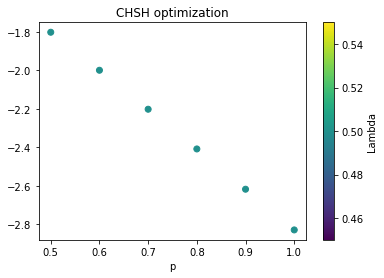

In [5]:
val = []
pval = []
qval = []
for run in results:
    val.append(run[0])
    pval.append(run[1])
    qval.append(run[2])
    print(f"{run[0]} at p = {run[1]} and q = {run[2]}")

print(val)
print(pval)
plt.figure()
plt.scatter(pval, val, c=qval, label=qval)
plt.title('CHSH optimization')
plt.xlabel('p')
plt.colorbar(label='Lambda')

### Convergenza Nelder-Mead nel caso sperimentale su singoletto di Bell

Optimization terminated successfully.
         Current function value: -2.832703
         Iterations: 669
         Function evaluations: 1586
Optimization terminated successfully.
         Current function value: -2.834941
         Iterations: 349
         Function evaluations: 746
Optimization terminated successfully.
         Current function value: -1.992964
         Iterations: 243
         Function evaluations: 519
Optimization terminated successfully.
         Current function value: -2.821149
         Iterations: 385
         Function evaluations: 814
Optimization terminated successfully.
         Current function value: -2.806466
         Iterations: 367
         Function evaluations: 739


<IPython.core.display.Javascript object>


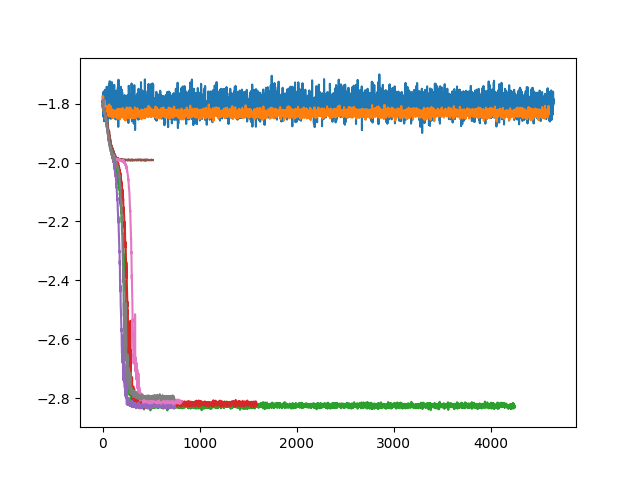

-1.8996507279651418
-1.8609101636747754
-2.841049454514355
-2.8327034533633704
-2.8349414287758243
-1.9929640929341867
-2.8211494492009055
-2.8064658042511166


In [9]:
#Inizia a convergere per N=10^5
state_exp = BellEnsemble(1,0)
N_exp = []
for N in [1000, 10000, 100000, 120000, 140000, 160000, 180000, 200000]:
    N_exp.append(OptimizationExperimental(state_exp, N))
    
plt.figure()
for run in N_exp:
    print(run.run.fun)
    plt.plot(run.history)

### Confronto ottimizzazione sperimental e esatta con Nelder-Mead, N~10^4

Puó essere un problema di scelta del punto iniziale?

In [10]:
#Experimental optimization
#MaxIter=1600 -> GROSSI PROBLEMI CON N~10^5
exp_states = []
exp_results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0,0.1,0.2,0.3,0.4,0.5]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationExperimental(teststate, 10000)
        exp_states.append(teststate)
        exp_results.append([testrun.run.fun,p,q])

Experimental Minimization
-0.9728276360164592 at p = 0.5 and q = 0
-0.9620928787336385 at p = 0.5 and q = 0.1
-0.9744478422914834 at p = 0.5 and q = 0.2
-0.9701980668809629 at p = 0.5 and q = 0.3
-0.9689613148423608 at p = 0.5 and q = 0.4
-0.9562062777071705 at p = 0.5 and q = 0.5
-1.148231689908369 at p = 0.6 and q = 0
-1.1389350656437318 at p = 0.6 and q = 0.1
-1.1463134739351486 at p = 0.6 and q = 0.2
-1.1450054369850895 at p = 0.6 and q = 0.3
-1.1458020442984487 at p = 0.6 and q = 0.4
-1.1459382847652886 at p = 0.6 and q = 0.5
-1.3186329481219405 at p = 0.7 and q = 0
-1.313770566305776 at p = 0.7 and q = 0.1
-1.322965892680065 at p = 0.7 and q = 0.2
-1.3245514649407095 at p = 0.7 and q = 0.3
-1.3263914350808583 at p = 0.7 and q = 0.4
-1.3202314505388681 at p = 0.7 and q = 0.5
-1.4940513055763307 at p = 0.8 and q = 0
-1.5003721164981467 at p = 0.8 and q = 0.1
-1.497071675640198 at p = 0.8 and q = 0.2
-1.491527747096013 at p = 0.8 and q = 0.3
-1.5057443500736472 at p = 0.8 and q = 0.

<IPython.core.display.Javascript object>


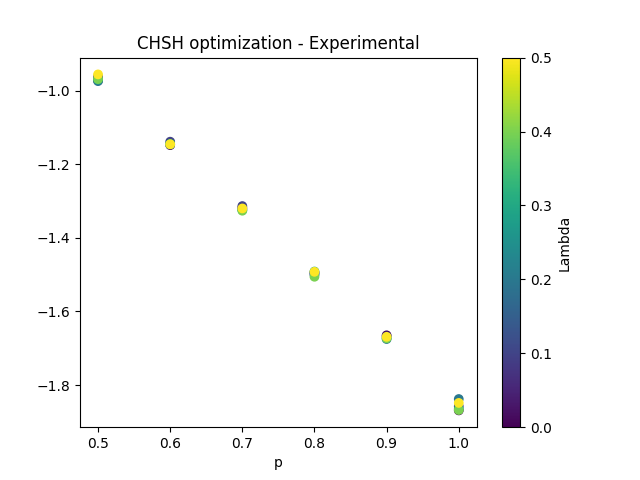

In [11]:
#Limite ottimizzazione Nelder-Mead, caso sperimentale
exp_val = []
exp_pval = []
exp_qval = []
print("Experimental Minimization")
for run in exp_results:
    exp_val.append(run[0])
    exp_pval.append(run[1])
    exp_qval.append(run[2])
    print(f"{run[0]} at p = {run[1]} and q = {run[2]}")

plt.figure()
plt.scatter(exp_pval, exp_val, c=exp_qval)
plt.title('CHSH optimization - Experimental')
plt.xlabel('p')
plt.colorbar(label='Lambda')

### Delta tra stima sperimentale e stima esatta Nelder-Mead

<IPython.core.display.Javascript object>


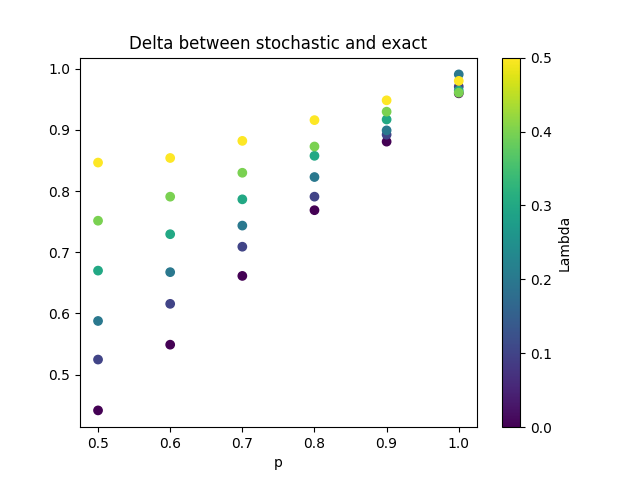

In [12]:
deltas = []
for i in range(len(val)):
    deltas.append(np.abs(val[i] - exp_val[i]))
plt.figure()
plt.scatter(exp_pval, deltas, c=exp_qval, label=exp_qval)
plt.title("Delta between stochastic and exact")
plt.xlabel('p')
plt.colorbar(label='Lambda')

# Study on best optimization algorithm for our approach

Candidates:

- NelderMead -> starts to work since N ~ 10^5
- Dual Annealing - Seems it doesn't work
- Powell -> seems to work
- LBFGS
- CG
- PyBOBYQA -> not too bad, lots of function calls
- Bayesian Optimization

Nota che i problemi grossi provengono dall'introduzione del parametro lambda

Optimization terminated successfully.
         Current function value: -2.828427
         Iterations: 457
         Function evaluations: 751
   direc: array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: array(-2.83762502)
 message: 'Optimization terminated successfully.'
    nfev: 623
     nit: 5
  status: 0
 success: True
       x: array([ 1.06530705,  0.70744483, -1.87444155,  0.86884059, -0.04100847,
        0.0828252 ,  1.16621094,  1.52973111])


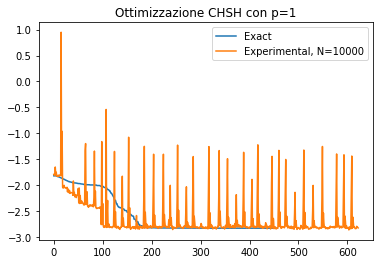

In [8]:
class OptimizationExperimental:
    def __init__(self, state, N, x0=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]):
        self.state = state
        self.history = []
        self.x0 = x0
        self.N = N
        #self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho, self.N),
        #                                   method='Nelder-Mead',
        #                                   options={'disp':True, 'maxiter':1600, 'xatol':0.001,
        #                                            'fatol':0.001, 'adaptive':False})
        #self.run = scipy.optimize.dual_annealing(self.func_free, [(0,3.14),(0,1.57),(0,3.14),(0,1.57),
        #                                                         (0,3.14),(0,1.57),(0,3.14),(0,1.57)],
        #                                         args=(self.state.rho, self.N))
        
        self.run = scipy.optimize.minimize(self.func_free,self.x0,args=(self.state.rho, self.N),
                                        method='Powell')
        
        #self.run = scipy.optimize.basinhopping(self.func_free, self.x0)
        
        #self.run = pybobyqa.solve(self.func_free, self.x0, objfun_has_noise=True)
        
        #self.run = gp_minimize(self.func_free, [(0,3.14),(0,1.57),(0,3.14),(0,1.57),(0,3.14),(0,1.57),(0,3.14),(0,1.57)],
        #                 base_estimator=None, n_calls=100)
        
    def dirvector(self, angles):
        return [np.cos(angles[0])*np.sin(angles[1]),np.sin(angles[0])*np.sin(angles[1]),np.cos(angles[1])]
    
    def exp_evaluation(self, op1, op2, rho, N):
        op1plus = op1.dp_plus
        op1minus = op1.dp_minus
        op2plus = op2.dp_plus
        op2minus = op2.dp_minus
        
        Npp = np.random.poisson(N*((tensor(op1plus,op2plus)*rho).tr()).real)
        Npm = np.random.poisson(N*((tensor(op1plus,op2minus)*rho).tr()).real)
        Nmp = np.random.poisson(N*((tensor(op1minus,op2plus)*rho).tr()).real)
        Nmm = np.random.poisson(N*((tensor(op1minus,op2minus)*rho).tr()).real)
        
        return (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
    
    def func_free(self, x, rho=None, N=None):
        if rho is None:
            rho = self.state.rho
        if N is None:
            N = self.N
        
        #rho è la matrice densità fissata in input
        #calcolo direzioni e operatori
        a0 = self.dirvector(x[0:2])
        a1 = self.dirvector(x[2:4])
        b0 = self.dirvector(x[4:6])
        b1 = self.dirvector(x[6:8])

        A0 = DicotomicProjector(a0)
        A1 = DicotomicProjector(a1)
        B0 = DicotomicProjector(b0)
        B1 = DicotomicProjector(b1)
        
        N00 = self.exp_evaluation(A0,B0,rho,N)
        N01 = self.exp_evaluation(A0,B1,rho,N)
        N10 = self.exp_evaluation(A1,B0,rho,N)
        N11 = self.exp_evaluation(A1,B1,rho,N)
        
        #Workaround alla funzione di callback
        #print(N00 + N01 + N10 - N11)
        self.history.append(N00 + N01 + N10 - N11)
        
        return N00 + N01 + N10 - N11

teststate = BellEnsemble(1,0)
basicrun = OptimizationRun(teststate)
exprun = OptimizationExperimental(teststate, 10000) #N~10
plt.figure()
plt.plot(basicrun.history, label='Exact')
plt.plot(exprun.history, label='Experimental, N=10000')
plt.legend()
plt.title('Ottimizzazione CHSH con p=1')
print(exprun.run)

In [9]:
states = []
results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationRun(teststate)
        states.append(teststate)
        results.append([testrun.run.fun,p,q])
exp_states = []
exp_results = []
for p in [0.5,0.6,0.7,0.8,0.9,1]:
    for q in [0]:
        teststate = BellEnsemble(p,q)
        testrun = OptimizationExperimental(teststate, 10000)
        exp_states.append(teststate)
        exp_results.append([testrun.run.fun,p,q])

Optimization terminated successfully.
         Current function value: -1.414214
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -1.697056
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -1.979899
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -2.262742
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -2.545584
         Iterations: 457
         Function evaluations: 751
Optimization terminated successfully.
         Current function value: -2.828427
         Iterations: 457
         Function evaluations: 751


Experimental Minimization
-1.426895934373503 at p = 0.5 and q = 0
-1.6621073648710663 at p = 0.6 and q = 0
-1.9975856769543006 at p = 0.7 and q = 0
-2.24877647384022 at p = 0.8 and q = 0
-2.557570551254031 at p = 0.9 and q = 0
-2.833109681399754 at p = 1 and q = 0


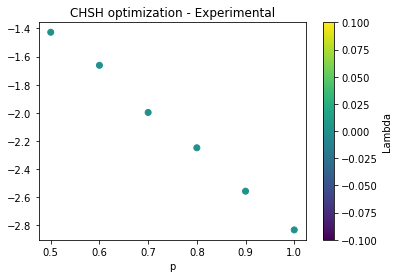

In [10]:
#Experimental minimizer
exp_val = []
exp_pval = []
exp_qval = []
exp_history = []
print("Experimental Minimization")
for run in exp_results:
    exp_val.append(run[0])
    exp_pval.append(run[1])
    exp_qval.append(run[2])
    print(f"{run[0]} at p = {run[1]} and q = {run[2]}")

plt.figure()
plt.scatter(exp_pval, exp_val, c=exp_qval)
plt.title('CHSH optimization - Experimental')
plt.xlabel('p')
plt.colorbar(label='Lambda')

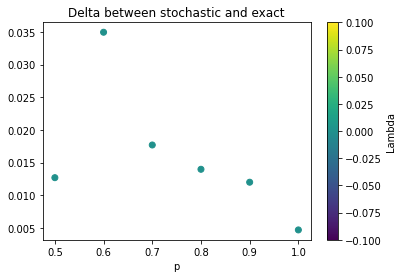

In [11]:
deltas = []
val = []
pval = []
qval = []
for run in results:
    val.append(run[0])
    pval.append(run[1])
    qval.append(run[2])
for i in range(len(val)):
    deltas.append(np.abs(val[i] - exp_val[i]))
plt.figure()
plt.scatter(exp_pval, deltas, c=exp_qval, label=exp_qval)
plt.title("Delta between stochastic and exact")
plt.xlabel('p')
plt.colorbar(label='Lambda')

In [12]:
print(exprun.run.fun)

-2.8376250189944114


# On the statistics of the measurement

Un po' di statistica sulla valutazione della funzione a N fissato.

In [20]:
exprun = OptimizationExperimental(teststate, 10000) # Just to use the predefined class
basicrun.run
# exprun.func_free(x) returns a single evaluation of the function

N_measurements = []
print("N - Media - DevStd - DevStd/Media")
for N in [1000, 10000, 100000, 1000000]:
    for i in range(10000):
        N_measurements.append(exprun.func_free([ 0.01314614,  0.54479095,  0.01787857, -1.02601143,  0.02510615, -0.24060813,  0.0160993 ,  1.33023856], None, N))
    
    print(N, np.mean(N_measurements), np.std(N_measurements), np.abs(np.std(N_measurements)/np.mean(N_measurements)))

          


N - Media - DevStd - DevStd/Media
1000 -2.8276517090915476 0.045168349587864275 0.015973802375532208
10000 -2.828065348765778 0.03342169757000238 0.011817866084526034
100000 -2.8281978862123682 0.027410890516724 0.009691998799077572
1000000 -2.8282533962390883 0.023749024835881913 0.008397064021018247
